<a href="https://colab.research.google.com/github/TheVioletRaven/NSE_OU/blob/master/Casus_Open_Universiteit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Notebook gemaakt door: Aukje Reina van Montfort (1704095), Silas Dannulis (2100940), Niema Mahmoudi (1807633) en Viktor Wenemoser (2101260)***

## Inleiding 

### Aanleiding
De tevredenheid van studenten is een cruciale indicator voor de kwaliteit van het onderwijs en de effectiviteit van onderwijsprogramma's. De Open Universiteit streeft ernaar om een leeromgeving te bieden die niet alleen academisch uitdagend is, maar ook voldoet aan de verwachtingen en behoeften van studenten. Inzicht in de factoren die de tevredenheid van studenten beïnvloeden, kan helpen om gerichte verbeteringen aan te brengen en zo de algehele studentervaring te optimaliseren. Traditionele methoden voor het evalueren van studententevredenheid bieden waardevolle informatie, maar missen vaak de diepgang en voorspellende kracht die nodig zijn om proactief veranderingen door te voeren. In dit kader biedt het gebruik van geavanceerde machine learning-technieken, zoals neurale netwerken, een potentieel krachtige benadering om diepere inzichten te verkrijgen en nauwkeurigere voorspellingen te doen over studententevredenheid.

### Doelstelling 
Dit onderzoek heeft als doel een neuraal netwerkmodel te ontwikkelen dat de algemene tevredenheid van studenten over hun opleiding voorspelt op basis van verschillende opleidingsgerelateerde kenmerken. Het model is ontworpen om nauwkeurige voorspellingen te doen en om inzicht te bieden in de belangrijkste factoren die de tevredenheid van studenten beïnvloeden. Door deze inzichten kan de universiteit sterke en zwakke punten in hun programma's identificeren, wat hen in staat stelt datagestuurde beslissingen te nemen ter verbetering van de kwaliteit van hun opleidingen.

### Methodologie 
Dit onderzoek maakt gebruik van een kwantitatieve benadering waarbij data-analyse en machine learning-technieken centraal staan. De dataset bestaat uit verschillende kenmerken die betrekking hebben op de opleiding en de tevredenheid van studenten. Deze data wordt geanalyseerd en gebruikt om een neuraal netwerkmodel te trainen. Zowel een model met Principal Component Analysis (PCA) als een model zonder PCA worden geëvalueerd om de nauwkeurigheid en voorspellende kracht te vergelijken. Verschillende visualisaties worden gebruikt om de resultaten en inzichten duidelijk te communiceren. Het onderzoek omvat de volgende stappen:

1. **Data Verzameling en Preprocessing**
   - De dataset wordt geladen en de relevante kenmerken en doelvariabelen worden gedefinieerd.
   - Er wordt een train-test split uitgevoerd op de dataset om trainings- en testdata te verkrijgen.

2. **Ontwikkeling van het Neuraal Netwerkmodel**
   - Een pipeline wordt opgezet met een `StandardScaler` en een `MLPRegressor`.
   - Een GridSearchCV wordt uitgevoerd om de beste hyperparameters voor het model te vinden.

3. **Evaluatie van het Model**
   - Het model wordt getraind op de trainingsdata en geëvalueerd op de testdata.
   - Prestatierubrieken zoals mean squared error (MSE) en R²-score worden berekend.
   - Cross-validatiescores worden berekend en weergegeven.

4. **Vergelijking van Modellen**
   - Zowel een model met PCA (om 90% van de variantie te verklaren) als een model zonder PCA worden geëvalueerd.
   - De prestaties van beide modellen worden vergeleken op basis van nauwkeurigheid en voorspellende kracht.

5. **Visualisatie van Resultaten**
   - De decision boundary van het model zonder PCA wordt gevisualiseerd met behulp van de belangrijkste features.
   - Verschillende visualisaties worden gebruikt om de resultaten en inzichten duidelijk te communiceren.

6. **Analyse en Rapportage**
   - De belangrijkste factoren die de tevredenheid van studenten beïnvloeden worden geanalyseerd.
   - De bevindingen worden gedocumenteerd en aanbevelingen voor verdere verbeteringen worden gegeven.



## Library imports

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import warnings

In [9]:
def remove_outliers(scaled_data):
    # IsolationForest model voor outliers verwijderen
    iso = IsolationForest(contamination=0.05)  # gewicht van outliers
    yhat = iso.fit_predict(scaled_data)
    
    # selecteer alle rijen dat geen outliers zijn
    mask = yhat != -1
    scaled_data_no_outliers = scaled_data[mask]
    
    return scaled_data_no_outliers

def process_pca(df, explained_variance_threshold=0.95):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Outlier verwijderen op scaled data
    scaled_data_no_outliers = remove_outliers(scaled_data)
    
    pca = PCA()
    pca_result = pca.fit(scaled_data_no_outliers)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(scaled_data_no_outliers))
    
    return pca_df, cumulative_variance, n_components, scaled_data_no_outliers, pca_result

# Neuraal Netwerk met PCA (verklaart 90% van de variantie)

Hoewel het neurale netwerk op 90% draait, worden enkel de eerste twee PCA-componenten gebruikt voor de visualisatie. Dit komt omdat elke volgende PCA-component steeds minder van de totale variantie verklaart. Door te concentreren op de grootst beschikbare PCA-componenten, kunnen de belangrijkste kenmerken gevisualiseerd worden. Dit helpt om de structuur en patronen in de data begrijpelijk en inzichtelijk te maken.

In [10]:
# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Laad de dataset
df = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

# Definiëren van de tevredenheidskolommen (doelvariabelen)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Definiëren van de kenmerken (X)
relevant_columns_nn = satisfaction_columns + ['INHOUDOPZET_THEMA', 'AANSLUITING_THEMA', 'DOCENTEN_THEMA', 
                                              'BEGELEIDING_THEMA', 'TOETSINGBEOORDELING_THEMA', 
                                              'BETROKKENHEIDCONTACT_THEMA', 'STUDIEDRUK_01', 
                                              'VAARDIGHEDEN_THEMA', 'STUDIELAST_THEMA', 
                                              'STUDIEFACILITEITEN_THEMA']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df[relevant_columns_nn].dropna()

# Kenmerken (X) en doelvariabelen (y) definiëren
X = filtered_data_nn.drop(columns=satisfaction_columns)
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline maken met PCA en MLPRegressor
pipeline = Pipeline([
    ('pca', PCA(n_components=0.90)),  # PCA aanpassen om 90% van de variantie te behouden
    ('mlpregressor', MLPRegressor(random_state=42, max_iter=2000, tol=1e-6, learning_rate_init=0.01, learning_rate='adaptive', solver="adam"))
])

# Hyperparameterrooster definiëren
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Toon enkele voorspellingen naast de werkelijke waarden
for i in range(10):
    print(f'Werkelijke waarde: {y_test.iloc[i]}, Voorspelde waarde: {y_pred[i]}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (128, 64), 'mlpregressor__solver': 'sgd'}
Mean Squared Error op de testset: 0.022435502321291847
R² op de testset: 0.44208112828410406
Cross-Validation Scores: [0.39161813 0.45661204 0.49763399 0.3915985  0.35394108]
Gemiddelde Cross-Validation Score: 0.4182807486534491
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8580461925732937
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8138277145650933
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8947324489040366
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8369043603615891
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8850950253196747
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9089611881922155
Werkelijke waarde: 0.75, Voorspelde waarde: 0.6904296109049173
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9554947890601965
Werkelijke waarde: 0.5, Voorspelde waarde: 

C:\Users\sdann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


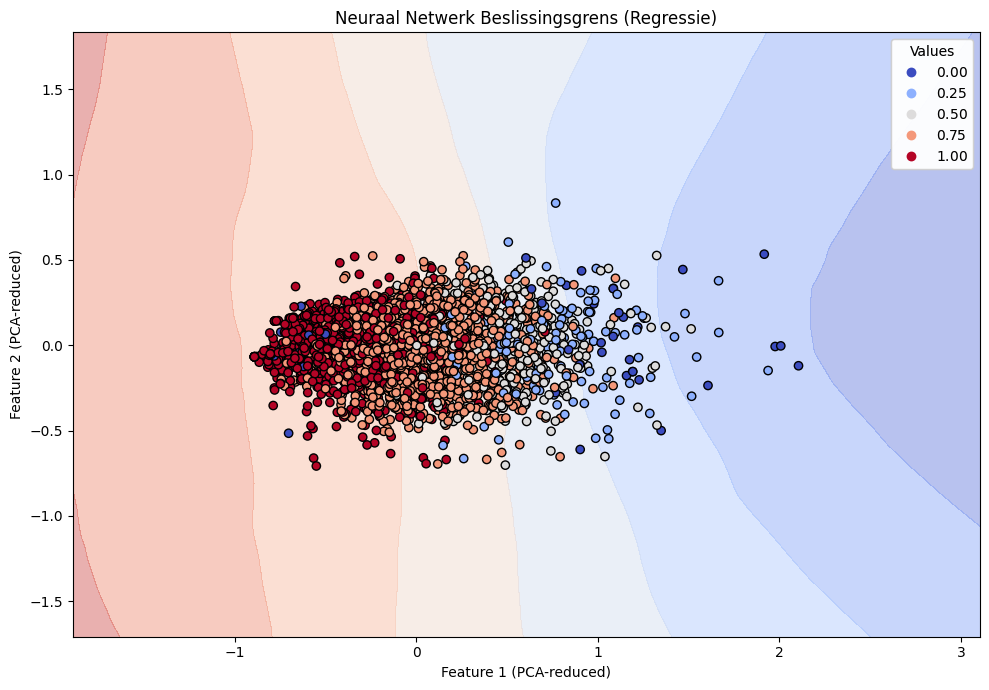

In [11]:
# Visualisatie van het neurale netwerk
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots
# Gebruik de eerste twee PCA-componenten voor de mesh grid
X_train_pca_visual = best_model.named_steps['pca'].transform(X_train)[:, :2]

xx, yy = np.meshgrid(
    np.linspace(X_train_pca_visual[:, 0].min() - 1, X_train_pca_visual[:, 0].max() + 1, 300),
    np.linspace(X_train_pca_visual[:, 1].min() - 1, X_train_pca_visual[:, 1].max() + 1, 300)
)
D_pca = np.c_[xx.ravel(), yy.ravel()]

# Inverse transform de mesh grid data naar de oorspronkelijke feature ruimte
D_original = best_model.named_steps['pca'].inverse_transform(np.c_[D_pca, np.zeros((D_pca.shape[0], best_model.named_steps['pca'].n_components_ - 2))])

# Voorspellingen maken met de beste MLPRegressor
Z = best_model.named_steps['mlpregressor'].predict(best_model.named_steps['pca'].transform(D_original))
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_pca_visual[:, 0], X_train_pca_visual[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Values")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens (Regressie)")
ax2.set_xlabel('Feature 1 (PCA-reduced)')
ax2.set_ylabel('Feature 2 (PCA-reduced)')

plt.tight_layout()
plt.show()

## Observaties:

**Hyperparameterselectie:**
Het model heeft de beste prestaties bereikt met de volgende hyperparameters: activation is ingesteld op 'relu', alpha (regularisatieparameter) op 0.01, hidden_layer_sizes op (128, 64), en solver op 'sgd'. Dit suggereert dat een relatief complexe netwerkarchitectuur met twee verborgen lagen en een 'ReLU' activatiefunctie, gecombineerd met een redelijk sterke regularisatie en de 'sgd' optimalisatie-algoritme, het beste werkte voor deze dataset.

**Modelprestaties op de testset:**
Het model behaalde een Mean Squared Error (MSE) van 0.022435502321291847 en een R²-score van 0.44208112828410406 op de testset. De R²-score geeft aan dat ongeveer 44.2% van de variantie in de doelvariabele kan worden verklaard door het model. Hoewel dit niet een bijzonder hoge R²-score is, suggereert het toch dat het model enige mate van voorspellende kracht heeft.

**Cross-Validation Scores:**
De cross-validatiescores variëren van 0.35394108 tot 0.49763399, met een gemiddelde score van 0.4182807486534491. Dit bevestigt dat het model redelijk consistent presteert over verschillende validatiesets, hoewel de scores enigszins variëren. Een gemiddelde R²-score van ongeveer 41.8% in cross-validatie komt overeen met de R²-score op de testset, wat de betrouwbaarheid van het model bevestigt.

**Voorspellingen versus werkelijke waarden:**
De voorspelde waarden liggen over het algemeen dicht bij de werkelijke waarden, maar er zijn enkele afwijkingen. Voorbeelden van voorspellingen zijn als volgt:

*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.8580461925732937
*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.8138277145650933
*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.8947324489040366
*   Werkelijke waarde: 0.75, Voorspelde waarde: 0.8369043603615891
*   Werkelijke waarde: 0.75, Voorspelde waarde: 0.8850950253196747

Deze voorspellingen laten zien dat het model meestal redelijk dicht bij de werkelijke waarden komt, maar dat er enige mate van voorspelfout aanwezig is. Dit wordt ook ondersteund door de MSE-score.

**Algemene prestaties:**
Hoewel het model niet perfect is, toont het aan dat het in staat is om een significante hoeveelheid van de variantie in de doelvariabele te verklaren en redelijk nauwkeurige voorspellingen te doen. De resultaten suggereren echter ook dat er ruimte is voor verbetering, bijvoorbeeld door het finetunen van hyperparameters, het toevoegen van meer data, of het gebruik van andere modelarchitecturen.

**Plot:**
De plot toont aan dat het model in staat is om een onderscheid te maken tussen verschillende voorspelde waarden, enkele observaties uit de afbeelding:
*   Er zit een duidelijke scheiding tussen de rode en blauwe gebieden, wat impliceert dat het model in staat is om patronen te leren en onderscheid te maken tussen verschillende voorspelde waarden.
*   Door de dimensiereductie met PCA kunnen de eerste twee componenten een groot deel van de variatie in de data verklaren, maar niet alle variatie. Dit wordt duidelijk in de plot waar sommige voorspellingen in de randen van de contouren niet perfect overeenkomen met de werkelijke waarden. 
*   De plot toont variabiliteit binnen clusters van data. Bijvoorbeeld, in de regio met lage voorspelde waarden (blauw), zijn er enkele rode en witte punten die op foutieve voorspellingen wijzen. Dit kan een indicatie zijn dat het model moeite heeft om sommige gevallen correct te classificeren, vooral in overlappende gebieden.

**Conclusie:**
De evaluatie toont dat het Neurale Netwerk met PCA redelijk goed presteert, met consistente resultaten over cross-validation en de testset.

# Neuraal Netwerk zonder PCA

In [12]:
# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Laad de dataset
df = pd.read_csv('NSE_Instellingsbestand_scaled.csv')

# Definiëren van de tevredenheidskolommen (doelvariabelen)
satisfaction_columns = ['TEVREDENHEIDALGEMEEN_01', 'TEVREDENHEIDALGEMEEN_02', 'TEVREDENHEIDALGEMEEN_03', 
                        'TEVREDENHEIDALGEMEEN_05', 'TEVREDENHEIDALGEMEEN_06', 'TEVREDENHEIDALGEMEEN_07',
                        'TEVREDENHEIDALGEMEEN_08', 'TEVREDENHEIDALGEMEEN_09', 'TEVREDENHEIDALGEMEEN_10',
                        'TEVREDENHEIDALGEMEEN_11', 'TEVREDENHEIDALGEMEEN_12']

# Definiëren van de kenmerken (X)
relevant_columns_nn = satisfaction_columns + ['INHOUDOPZET_THEMA', 'AANSLUITING_THEMA', 'DOCENTEN_THEMA', 
                                              'BEGELEIDING_THEMA', 'TOETSINGBEOORDELING_THEMA', 
                                              'BETROKKENHEIDCONTACT_THEMA', 'STUDIEDRUK_01', 
                                              'VAARDIGHEDEN_THEMA', 'STUDIELAST_THEMA', 
                                              'STUDIEFACILITEITEN_THEMA']

# Dataset filteren om alleen de relevante kolommen op te nemen
filtered_data_nn = df[relevant_columns_nn].dropna()

# Kenmerken (X) en doelvariabelen (y) definiëren
X = filtered_data_nn.drop(columns=satisfaction_columns)
y = filtered_data_nn['TEVREDENHEIDALGEMEEN_01']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline maken met StandardScaler en MLPRegressor
pipeline = Pipeline([
    ('mlpregressor', MLPRegressor(random_state=42, max_iter=2000, tol=1e-6, learning_rate_init=0.01, learning_rate='adaptive', solver="adam"))
])

# Hyperparameterrooster definiëren
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(64, 32), (128, 64), (64,)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__solver': ['adam', 'sgd'],
    'mlpregressor__alpha': [0.0001, 0.001, 0.01]
}

# GridSearchCV instellen
scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scorer, n_jobs=-1, verbose=2)

# Grid search uitvoeren om de beste hyperparameters te vinden
grid_search.fit(X_train, y_train)

# Beste hyperparameters ophalen
best_params = grid_search.best_params_
print(f'Beste hyperparameters: {best_params}')

# Beste model trainen met de volledige trainingsset
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Voorspellingen maken op de testset
y_pred = best_model.predict(X_test)

# Het model evalueren
test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error op de testset: {test_mse}')
print(f'R² op de testset: {r2}')

# Cross-validatiescores berekenen en weergeven
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=kf, scoring=scorer)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Gemiddelde Cross-Validation Score: {cv_scores.mean()}')

# Toon enkele voorspellingen naast de werkelijke waarden
for i in range(10):
    print(f'Werkelijke waarde: {y_test.iloc[i]}, Voorspelde waarde: {y_pred[i]}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Beste hyperparameters: {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.0001, 'mlpregressor__hidden_layer_sizes': (64, 32), 'mlpregressor__solver': 'sgd'}
Mean Squared Error op de testset: 0.02052157616025859
R² op de testset: 0.48967602983876324
Cross-Validation Scores: [0.44699112 0.49675545 0.53210741 0.41339865 0.36408965]
Gemiddelde Cross-Validation Score: 0.4506684574571513
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8373561769815902
Werkelijke waarde: 1.0, Voorspelde waarde: 0.8326129930412384
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9154718963415808
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8128757348954255
Werkelijke waarde: 0.75, Voorspelde waarde: 0.8399820551674583
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9128648232005193
Werkelijke waarde: 0.75, Voorspelde waarde: 0.7591298610307553
Werkelijke waarde: 1.0, Voorspelde waarde: 0.9726091270251939
Werkelijke waarde: 0.5, Voorspelde waarde: 

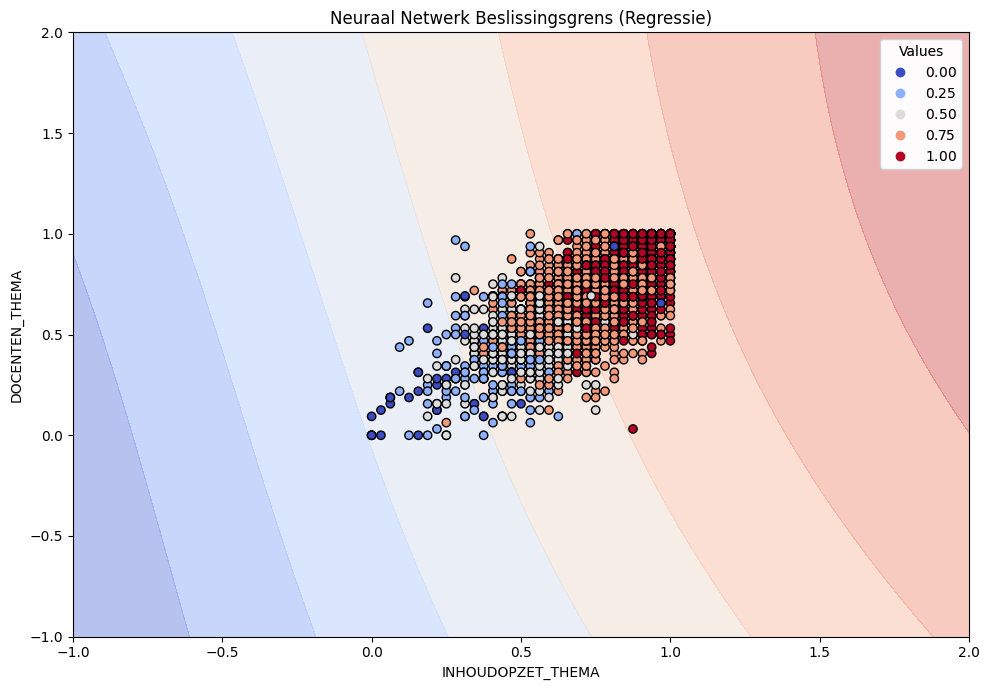

In [15]:
# Visualisatie van het neurale netwerk zonder PCA
fig, ax2 = plt.subplots(figsize=(10, 7))

# Voorbereiden van de mesh grid voor contour plots met de belangrijkste features voor visualisatie
X_train_subset = X_train[['INHOUDOPZET_THEMA', 'DOCENTEN_THEMA']]

xx, yy = np.meshgrid(
    np.linspace(X_train_subset.iloc[:, 0].min() - 1, X_train_subset.iloc[:, 0].max() + 1, 300),
    np.linspace(X_train_subset.iloc[:, 1].min() - 1, X_train_subset.iloc[:, 1].max() + 1, 300)
)
D = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X_train_subset.columns)

# Vul de ontbrekende kolommen in met het gemiddelde van de trainingsdata
for col in X_train.columns:
    if col not in D.columns:
        D[col] = X_train[col].mean()

# Zorg ervoor dat de volgorde van de kolommen hetzelfde is als tijdens het trainen
D = D[X_train.columns]

# Voorspellingen maken met de beste MLPRegressor
Z = best_model.predict(D)
Z = Z.reshape(xx.shape)

# Plot de decision boundary
ax2.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)

# Plot de trainingsdata
scatter = ax2.scatter(X_train_subset.iloc[:, 0], X_train_subset.iloc[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Voeg een kleurlegenda toe
legend1 = ax2.legend(*scatter.legend_elements(), title="Values")
ax2.add_artist(legend1)

# Titel en labels instellen
ax2.set_title("Neuraal Netwerk Beslissingsgrens (Regressie)")
ax2.set_xlabel('INHOUDOPZET_THEMA')
ax2.set_ylabel('DOCENTEN_THEMA')

plt.tight_layout()
plt.show()

## Observaties:

**Hyperparameterselectie:**
Het model heeft de beste prestaties bereikt met de volgende hyperparameters: activation is ingesteld op 'tanh', alpha (regularisatieparameter) op 0.0001, hidden_layer_sizes op (64, 32), en solver op 'sgd'. Dit suggereert dat een minder complexe netwerkarchitectuur met twee verborgen lagen en de 'tanh' activatiefunctie, gecombineerd met een zwakkere regularisatie en de 'sgd' optimalisatie-algoritme, het beste werkte voor deze dataset zonder PCA.

**Modelprestaties op de testset:***
Het model behaalde een Mean Squared Error (MSE) van 0.02052157616025859 en een R²-score van 0.48967602983876324 op de testset. De R²-score geeft aan dat ongeveer 48.97% van de variantie in de doelvariabele kan worden verklaard door het model. Dit is een verbetering ten opzichte van het model met PCA, wat suggereert dat het model zonder PCA iets beter presteert.

**Cross-Validation Scores:**
De cross-validatiescores variëren van 0.36408965 tot 0.53210741, met een gemiddelde score van 0.4506684574571513. Dit bevestigt dat het model redelijk consistent presteert over verschillende validatiesets, met iets betere scores dan het model met PCA. De gemiddelde R²-score van ongeveer 45.07% in cross-validatie komt ook overeen met de R²-score op de testset, wat de betrouwbaarheid van het model bevestigt.

**Voorspellingen versus werkelijke waarden:**
De voorspelde waarden liggen over het algemeen dicht bij de werkelijke waarden, met enkele voorbeelden als volgt:

*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.8373561769815902
*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.8326129930412384
*   Werkelijke waarde: 1.0, Voorspelde waarde: 0.9154718963415808
*   Werkelijke waarde: 0.75, Voorspelde waarde: 0.8128757348954255
*   Werkelijke waarde: 0.75, Voorspelde waarde: 0.8399820551674583

Deze voorspellingen laten zien dat het model meestal redelijk dicht bij de werkelijke waarden komt, en over het algemeen beter dan het model met PCA.

**Algemene prestaties:**
Het model zonder PCA presteert beter dan het model met PCA, zowel qua MSE als R²-score. Dit suggereert dat het model baat heeft bij het behouden van de volledige complexiteit en variatie in de data, zonder dimensiereductie. De consistentie in de cross-validatiescores en de betere prestaties op de testset wijzen erop dat dit model robuuster en beter in staat is om de doelvariabele te voorspellen.

**Plot:**
*   De contourlijnen in de plot vertegenwoordigen verschillende niveaus van voorspelde waarden van het model. De kleuren variëren van blauw tot rood, waarbij blauw de lagere voorspelde waarden (dicht bij 0.0) en rood de hogere voorspelde waarden (dicht bij 1.0) vertegenwoordigen. De beslissingsgrens is waar de kleur overgaat van blauw naar rood.
*   De gegevenspunten zijn geconcentreerd in een specifieke regio van de plot. De meeste punten bevinden zich in een cluster tussen 0.0 en 1.0 op zowel de x-as (INHOUDOPZET_THEMA) als de y-as (DOCENTEN_THEMA). Dit suggereert dat deze kenmerken samenhang vertonen en mogelijk correleren met de doelvariabele.
*   De x-as vertegenwoordigt de variabele INHOUDOPZET_THEMA en de y-as vertegenwoordigt de variabele DOCENTEN_THEMA. De interactie tussen deze twee kenmerken lijkt een belangrijke rol te spelen in de voorspellingen van het model. De duidelijke kleurgradaties suggereren dat het model gevoelig is voor veranderingen in beide kenmerken.
*   De meeste gegevenspunten zijn geconcentreerd rond specifieke waarden, wat aangeeft dat deze kenmerken waarschijnlijk belangrijk zijn voor de voorspellingen van de doelvariabele. Het model lijkt goed te presteren binnen deze geconcentreerde clusters.

**Vergelijking met PCA-model:**
Mean Squared Error (MSE): Lager bij het model zonder PCA (0.0205 vs. 0.0224), wat wijst op betere prestaties.
R²-score: Hoger bij het model zonder PCA (0.4897 vs. 0.4421), wat aangeeft dat dit model meer variantie in de data kan verklaren.
Cross-Validation Scores: Gemiddelde score is hoger bij het model zonder PCA (0.4507 vs. 0.4183), wat wijst op betere en consistentere prestaties.

**Conclusie:**
Het neurale netwerkmodel zonder PCA presteert beter dan het model met PCA, zoals blijkt uit de hogere R²-score, lagere MSE, en consistentere cross-validatiescores. Het behoud van de volledige variatie in de data zonder dimensiereductie lijkt gunstig voor de voorspellende kracht van het model. De visuele representatie ondersteunt deze bevindingen door aan te tonen dat het model duidelijke en stabiele beslissingsgrenzen heeft geleerd. Al met al blijkt het neurale netwerk zonder PCA effectief te zijn in het voorspellen van tevredenheidsscores.

## Residual plot

Een residual plot wordt gebruikt om de residuen van een model te visualiseren. Residuen zijn de verschillen tussen de werkelijke waarden en de voorspelde waarden van een model. De residuen worden berekend door de voorspelde waarden af te trekken van de werkelijke waarden. Vervolgens wordt een scatter plot gemaakt met de voorspelde waarden op de x-as en de residuen op de y-as. In deze plot wordt een horizontale lijn bij y=0 getekend om aan te geven waar de residuen nul zijn. Het doel van een residual plot is om de kwaliteit van het model te beoordelen. Als de residuen willekeurig verspreid zijn rondom de horizontale lijn bij y=0, dan is het model geschikt voor de data. Systematische patronen in de residual plot kunnen wijzen op problemen zoals een niet-lineaire relatie of heteroscedasticiteit.

De belangrijkheid van kenmerken (features) in een neuraal netwerk wordt geëvalueerd door de gewichten van de kenmerken in het model te analyseren. De belangrijkheid van elk kenmerk wordt berekend door de absolute som van de gewichten van de eerste laag van het neurale netwerk te nemen. De belangrijkheid van de kenmerken wordt vervolgens gevisualiseerd met een horizontale staafdiagram. In deze visualisatie wordt de absolute waarde van de gewichten gebruikt om de relatieve belangrijkheid van elk kenmerk te bepalen. Een hogere absolute waarde van een gewicht geeft aan dat het overeenkomstige kenmerk een grotere invloed heeft op de output van het model. Deze analyse helpt bij het begrijpen van welke kenmerken het meest bijdragen aan de voorspellingen van het model.

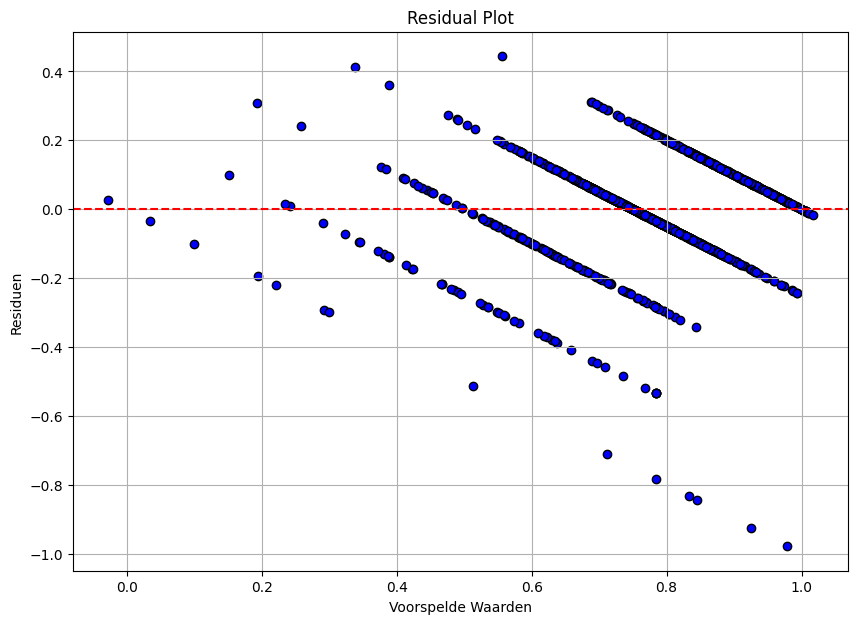

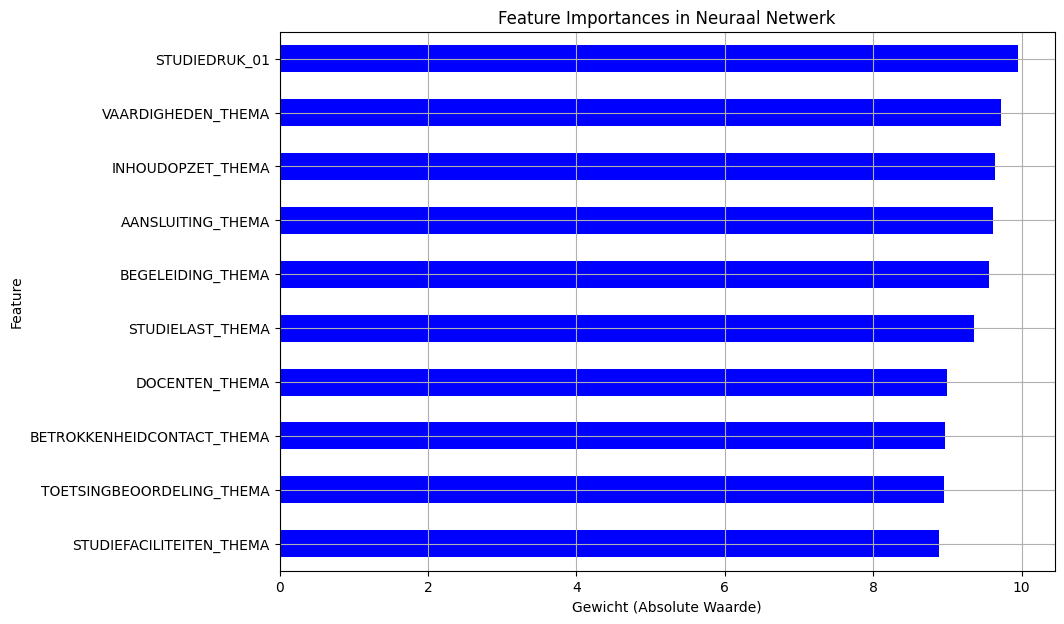

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Voorspelde Waarden')
plt.ylabel('Residuen')
plt.title('Residual Plot')
plt.grid()
plt.show()

importances = np.abs(best_model.named_steps['mlpregressor'].coefs_[0]).sum(axis=1)
feature_importances = pd.Series(importances, index=X_train.columns)

plt.figure(figsize=(10, 7))
feature_importances.sort_values().plot(kind='barh', color='b')
plt.title('Feature Importances in Neuraal Netwerk')
plt.xlabel('Gewicht (Absolute Waarde)')
plt.ylabel('Feature')
plt.grid()
plt.show()